In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from utils import rnmse
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Subset
from neuralop import FNO
import pandas as pd
import seaborn as sns
import matplotlib
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('hot', n_colors=7)
plt.rc('text', usetex=True)      

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

Error: trying to import DISCO convolutions without optional dependency torch-harmonics.  Please install with `pip install torch-harmonics` and retry.


In [2]:
X = torch.cat([torch.load("../dataset/x_train.pt"), torch.load("../dataset/x_train_2.pt")])
y = torch.cat([torch.load("../dataset/y_train.pt"), torch.load("../dataset/y_train_2.pt")])
c = torch.cat([torch.load("../dataset/c_train.pt"), torch.load("../dataset/c_train_2.pt")])

X_test = torch.load("../dataset/x_test.pt")
y_test = torch.load("../dataset/y_test.pt")
c_test = torch.load("../dataset/c_test.pt")

In [3]:
X.shape

torch.Size([27000, 256, 128])

In [4]:
class ResidualRegressor(BaseEstimator):
    def __init__(self, regressor, n_components=64):
        self.n_components = n_components
        self.pipe_lm = TransformedTargetRegressor(
            regressor=Pipeline([
                ("pca", PCA(n_components=self.n_components)),
                ("lm", LinearRegression(n_jobs=-1))
            ]),
            transformer=PCA(n_components=self.n_components),
            check_inverse=False
        )
        self.regressor = regressor

    def fit(self, X, y):
        X_np, y_np = X.numpy().reshape((X.shape[0], -1)), y.numpy().reshape((y.shape[0], -1))
        self.pipe_lm.fit(X_np, y_np)
        y_hat_lm = torch.tensor(self.pipe_lm.predict(X).reshape(y.shape))
        self.regressor.fit(X, y-y_hat_lm)

    def predict(self, X):
        return torch.tensor(self.regressor.predict(X.reshape((X.shape[0], -1))).reshape(X.shape)) + self.pipe_lm.predict(X)

In [5]:
def scorer_rnmse(estimator, x, y):
    return rnmse(estimator.predict(x), y)

In [6]:
n_points = 1024#x.shape[0]
n_cv = 5
n_epochs = 500

In [7]:
scores = {}

In [22]:
class CNN(nn.Module):
    def __init__(self, input_dim=(X.shape[1:]), output_dim=(y.shape[1:])):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * input_dim[0]*input_dim[1], 128),
            nn.ReLU(),
            nn.Linear(128, output_dim[0]*output_dim[1])
        )

    def forward(self, x):
        return self.head(self.features(x.unsqueeze(1))).reshape(x.shape)

In [23]:
def get_rnmse():
    return rnmse

device = 'mps'

In [24]:
from skorch import NeuralNet

model = NeuralNet(
            CNN,
            max_epochs=n_epochs,
            criterion=get_rnmse,
            optimizer=optim.Adam,
            lr=1e-3,
            iterator_train__shuffle=False,
            device=device
    )

model.fit(X[:n_points], y[:n_points])

#scores["CNN"] = cross_val_score(
#    pipe_cnn,
#    X[:n_points], y[:n_points],
#    cv=n_cv,
#    scoring=scorer_rnmse,
    #n_jobs=-1,
#    verbose=1
#)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        2.4204        1.0032  20.5646
      2        1.0024        1.0015  18.9933


,module,<class '__main__.CNN'>
,criterion,<function get...t 0x30a8a2520>
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.001
,max_epochs,500
,batch_size,128
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>
,train_split,<skorch.datas...t 0x14b7592d0>
,callbacks,None


data = pd.DataFrame(scores)[sorted(scores, key=lambda x: np.mean(scores[x]), reverse=True)]
data.to_csv('results.csv')
data

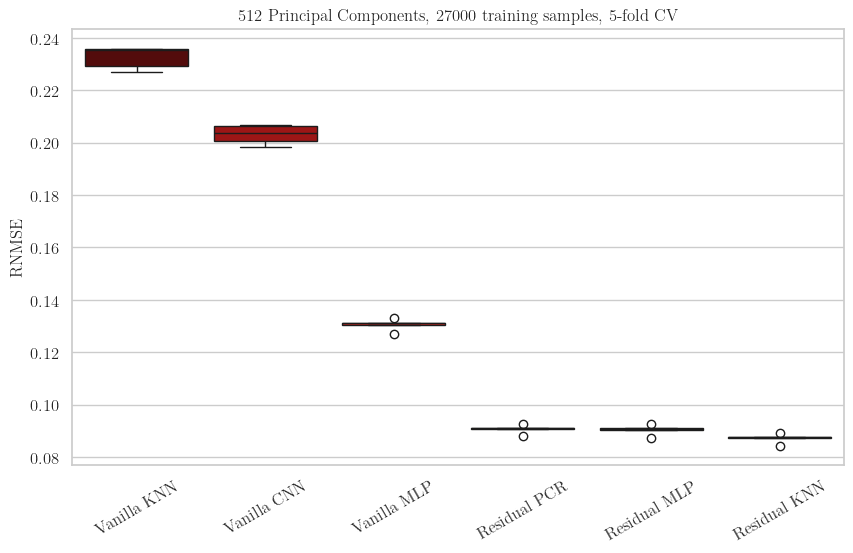

In [13]:
data = pd.read_csv("results.csv")
del data["Vanilla LM"]
plt.figure(figsize=(9, 6))
plt.title(f"{n_components_pca} Principal Components, {n_points} training samples, {n_cv}-fold CV")
sns.boxplot(data)
plt.ylabel("RNMSE")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('results.jpg', dpi=150)
plt.show()

In [16]:
data.mean(), data.std()

(Vanilla KNN     0.232599
 Vanilla CNN     0.203123
 Vanilla MLP     0.130574
 Residual PCR    0.090707
 Residual MLP    0.090468
 Residual KNN    0.087188
 dtype: float64,
 Vanilla KNN     0.004243
 Vanilla CNN     0.003659
 Vanilla MLP     0.002257
 Residual PCR    0.001651
 Residual MLP    0.001930
 Residual KNN    0.001696
 dtype: float64)